In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
from scripts import *

Global seed set to 10


In [5]:
if not Path('watermark_deletion').exists():
    if not Path('watermark_deletion.zip').exists():
        !yadisk https://disk.yandex.ru/d/376HEMoVlufD9g
    !unzip watermark_deletion.zip
    !unzip watermark_deletion/data_generation.zip

## Загрузка обучающих данных

In [6]:
data_path = Path('watermark_deletion')

In [7]:
with open(data_path / "train_true_images.npy", "rb") as f:
    train_true_images = np.load(f).astype('int32')
    print('train true shape:', train_true_images.shape)
with open(data_path / "train_corrupted_images.npy", "rb") as f:
    train_corrupted_images = np.load(f).astype('int32')
    print('train corrupted shape:', train_corrupted_images.shape)

train true shape: (4000, 128, 128, 3)
train corrupted shape: (4000, 128, 128, 3)


Всего в обучающем множестве 4000 изображений размера $128\times 128\times 3$. Визуализируем по одному примеру из `train_true_images` и `train_corrupted_images`

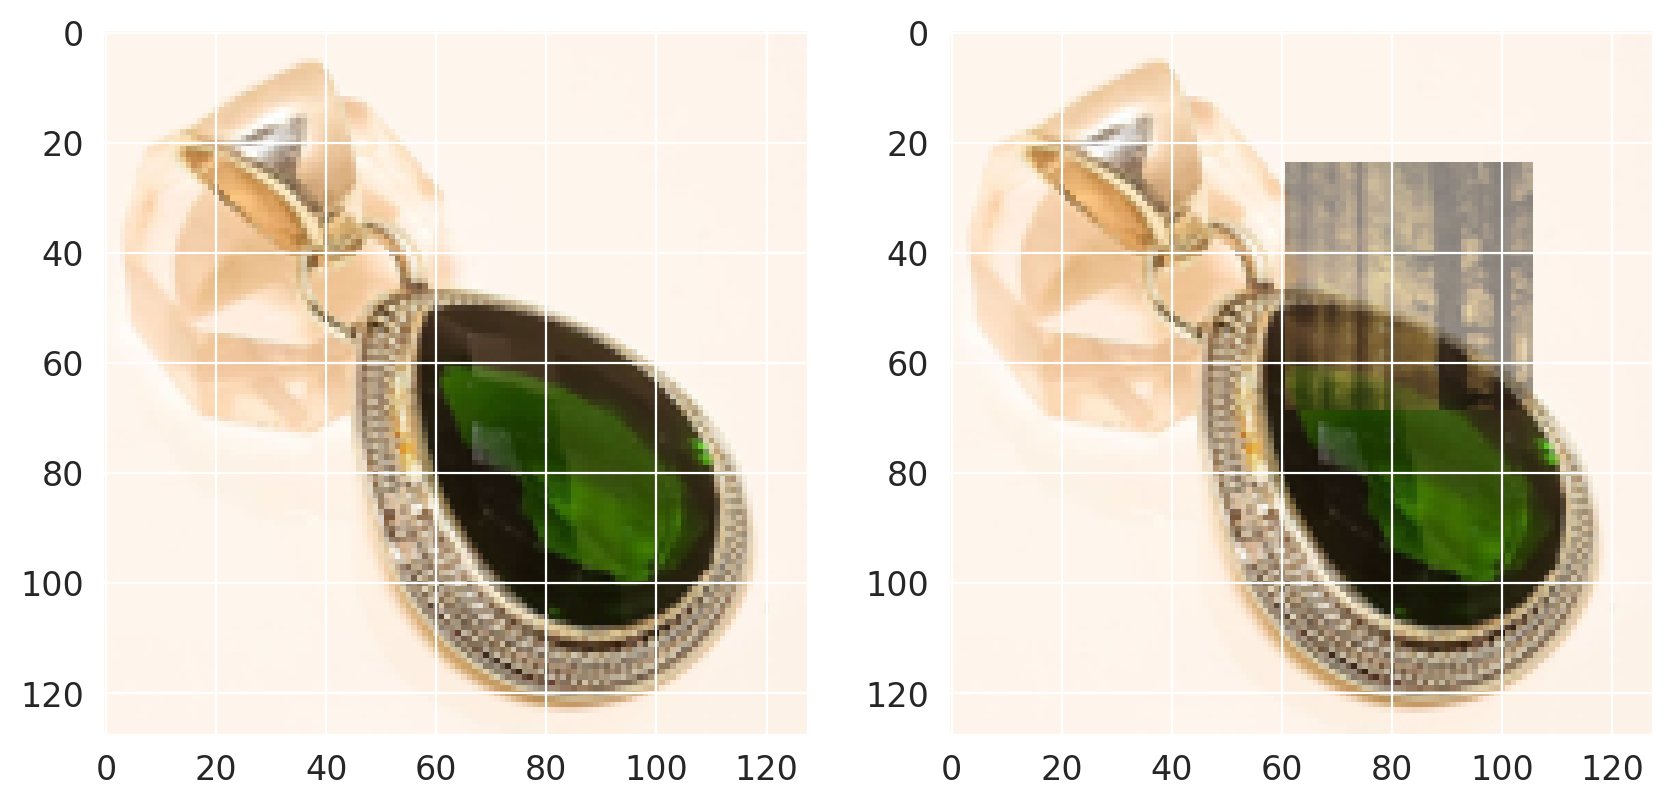

In [8]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].imshow(train_true_images[10])
axs[1].imshow(train_corrupted_images[10])

Видим, что `corrupted_image` содержит вотермарку.

In [9]:
train_dataset = ImgClassDataset(train_true_images, train_corrupted_images)

In [10]:
train_loader = DataLoader(train_dataset, num_workers=4, batch_size=50, shuffle=True)
# test_loader = DataLoader(test_dataset, num_workers=4, batch_size=50, shuffle=False)

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_checkpoint = ModelCheckpoint(
    dirpath="saved/",
    filename="{epoch}-{val_mae:.3f}",
    monitor="train_mae",
    mode="min",
    save_top_k=1,
)


model_lightning = ModelLightning(freeze='full')

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    gradient_clip_val=0.5,
    callbacks=[model_checkpoint],
    precision="16"
)

trainer.fit(
    model=model_lightning,
    train_dataloaders=train_loader
)

/media/black_chick/Notes/HSE/CV_course/cv_env/lib/python3.9/site-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/black_chick/Notes/HSE/CV_course/cv_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch

Training: 0it [00:00, ?it/s]

/media/black_chick/Notes/HSE/CV_course/cv_env/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_mae')` could not find the monitored key in the returned metrics: ['train_mae', 'train_loss', 'epoch', 'step']. HINT: Did you call `log('val_mae', value)` in the `LightningModule`?
  warning_cache.warn(m)


Epoch 00004: reducing learning rate of group 0 to 2.0000e-05.
Epoch 00007: reducing learning rate of group 0 to 4.0000e-06.


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 8.0000e-07.


## Метрика
Метрикой в данной задаче является среднее абсолютное отклонение пикселей восстановленного изображения от настоящего по всем пикселям изображения, по всем трём каналам и по всем изображениям.

In [12]:
from sklearn.metrics import mean_absolute_error

def compute_metrics(true_images, pred_images):
    """
    true_mask[batch_size, 128, 128, 3]: np.array
    pred_mask[batch_size, 128, 128, 3]: np.array
    """
    assert true_images.shape[1:] ==  (128, 128, 3), 'Check true_mask shape'
    assert pred_images.shape[1:] ==  (128, 128, 3), 'Check pred_mask shape'
    assert true_images.shape == pred_images.shape, 'Mask shapes do not align'

    return mean_absolute_error(true_images.ravel(), pred_images.ravel())
    

Посмотрим, чему равна метрика на обучающей выборке, если в качестве предсказанных изображений брать исходные изображения с вотермарками

In [13]:
metric = compute_metrics(train_true_images, train_corrupted_images).round(5)

print(f"Отклонение тривиальных предсказаний на обучающей выборке: {metric}")

Отклонение тривиальных предсказаний на обучающей выборке: 4.05303


## Загрузка тестовых данных

In [14]:
with open(data_path / "test_corrupted_images.npy", "rb") as f:
    test_corrupted_images = np.load(f).astype(int)

test_corrupted_images.shape

(2000, 128, 128, 3)

Всего 2000 изрбражений в тестовом множестве, все с вотермарками.

In [15]:
test_true_images = restore(model_lightning, test_corrupted_images[:500, ...])
test_true_images.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 125.32it/s]


(50, 128, 128, 3)

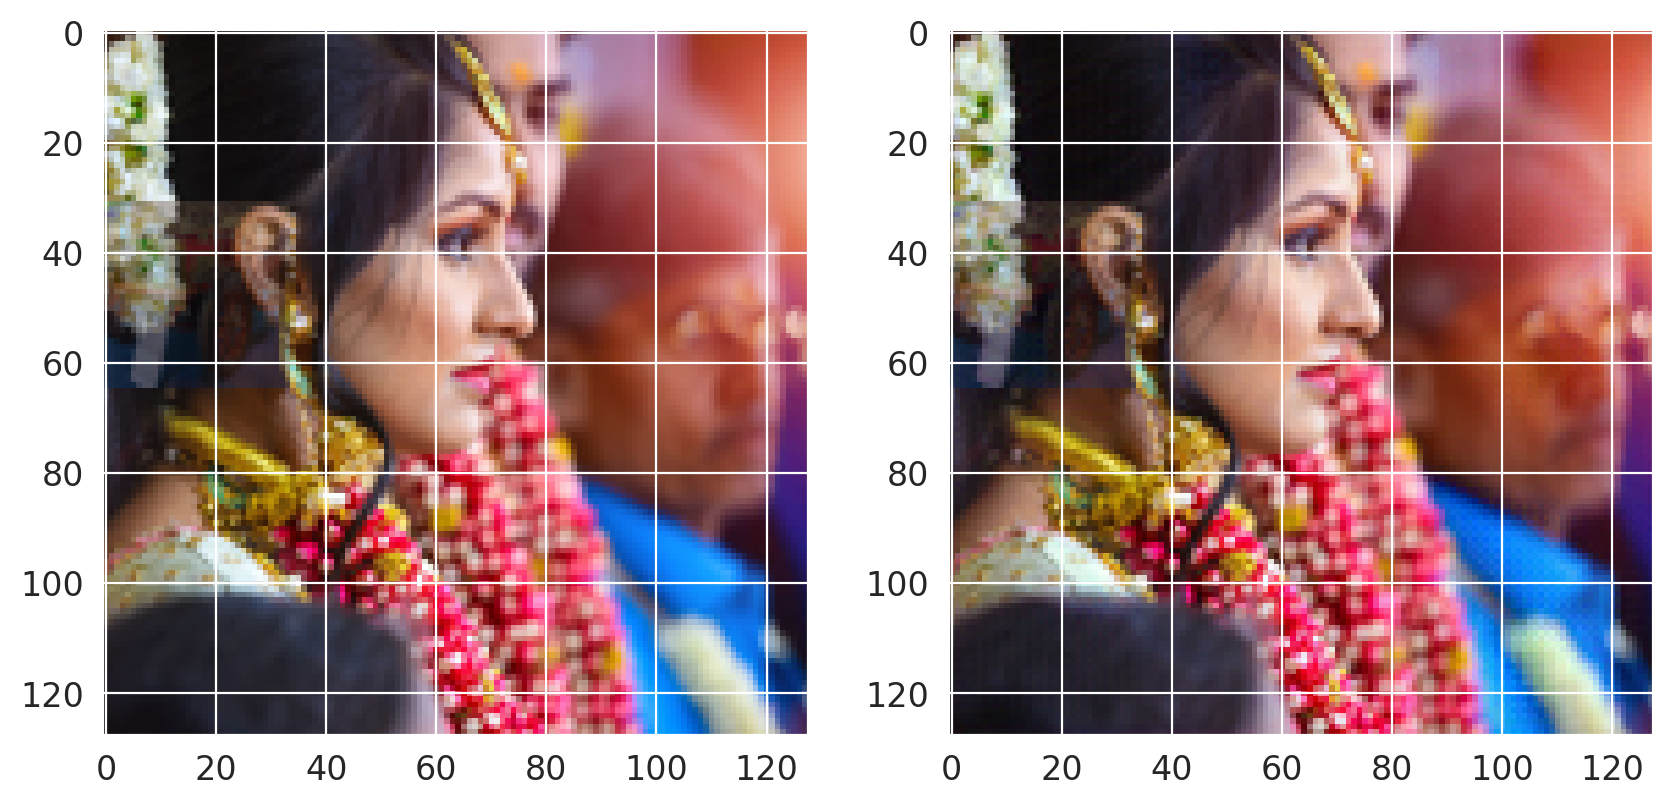

In [26]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
n = 6
axs[0].imshow(test_corrupted_images[n])
axs[1].imshow(test_true_images[n])

In [19]:
with open("submit.npy", "wb") as f:
    np.save(f, test_true_images.astype('uint8'), allow_pickle=False)